In [92]:
import torch
from spikingjelly.activation_based import neuron, base, surrogate
import matplotlib.pyplot as plt
from typing import Callable, Optional
import os, pandas as pd
import torch.nn.functional as F
import torch.nn as nn

In [93]:
#src_file_path = '/home/hwkang/dev-TSB-AD/TSB-AD/Datasets/TSB-AD-M/065_SMD_id_9_Facility_tr_737_1st_837.csv'
src_file_path = '/home/hwkang/dev-TSB-AD/TSB-AD/Datasets/TSB-AD-M/173_GECCO_id_1_Sensor_tr_16165_1st_16265.csv'

window_size = 1000
start_idx = 0

df = pd.read_csv(src_file_path)
data = df.iloc[start_idx:start_idx+window_size, 0].values
data = torch.tensor(data, dtype=torch.float32)
data = data.unsqueeze(0).unsqueeze(0) # (1, 1, 200)

In [94]:
# adaptive maxpool1d should get (1, L, 1)
def adaptive_maxpool1d(input: torch.Tensor, output_size: int) -> torch.Tensor:
    """
    Adaptive max pooling for 1D input.
    :param input: Input tensor of shape (N, C, L)
    :param output_size: Desired output size
    :return: Pooled tensor of shape (N, C, output_size)
    """
    return F.adaptive_max_pool1d(input, output_size)

# adaptive averagepool1d
def adaptive_avgpool1d(input: torch.Tensor, output_size: int) -> torch.Tensor:
    """
    Adaptive average pooling for 1D input.
    :param input: Input tensor of shape (N, C, L)
    :param output_size: Desired output size
    :return: Pooled tensor of shape (N, C, output_size)
    """
    return F.adaptive_avg_pool1d(input, output_size)

In [95]:
tmp_data = df.iloc[start_idx:start_idx+window_size, :].values
tmp_data = torch.tensor(tmp_data, dtype=torch.float32)
tmp_data = tmp_data.unsqueeze(0) # (1, L, C)

In [96]:
tmp_data.shape

torch.Size([1, 1000, 10])

In [97]:
attention_ratio = 0.5
fc1 = nn.Linear(window_size, int(window_size * attention_ratio))
fc2 = nn.Linear(int(window_size * attention_ratio), window_size)
relu = nn.ReLU()

In [98]:
data_mp = adaptive_maxpool1d(tmp_data, 1) # (1, 1, L) < (1, L, 1)
data_ap = adaptive_avgpool1d(tmp_data, 1) # (1, 1, L) < (1, L, 1)

data_mp = fc1(data_mp.squeeze(-1))
data_mp = relu(data_mp)
data_mp = fc2(data_mp)

data_ap = fc1(data_ap.squeeze(-1))
data_ap = relu(data_ap)
data_ap = fc2(data_ap)

attention = data_mp + data_ap
# Normalize attention to [0, 1] range
attention = (attention - attention.min()) / (attention.max() - attention.min() + 1e-8)  # Avoid division by zero

#normalized = (data - data_ap) / (data_mp - data_ap + 1e-8)  # Avoid division by zero
data_attention = F.sigmoid(attention)
data_attention = data_attention.unsqueeze(-1).permute(0, 2, 1) # (1, 1, L)

# visualize the attention
data_mp = data_mp.unsqueeze(-1).permute(0, 2, 1) # (1, 1, L)
data_ap = data_ap.unsqueeze(-1).permute(0, 2, 1) # (1, 1, L)

In [ ]:
# Channel attention

In [99]:
data_mp.shape

torch.Size([1, 1, 1000])

In [100]:
data_attention.shape

torch.Size([1, 1, 1000])

In [101]:
def split_low_high(x, cutoff_ratio=0.25):
        """
        x : (B, C, L) real tensor
        cutoff_ratio : 0~1, 비율로 구분 (예: 0.25 → Nyquist의 25% 이하를 저주파로)
        반환값       : low, high  (둘 다 (B, C, L))
        """
        B, C, L = x.shape
        N_fft   = L // 2 + 1                     # rfft length
        k_c     = int(cutoff_ratio * (N_fft - 1))

        # 1) FFT
        Xf = torch.fft.rfft(x, dim=-1)           # (B, C, N_fft), complex64/128

        # 2) 주파수 마스크
        mask = torch.zeros(N_fft, device=x.device, dtype=torch.bool)
        mask[:k_c + 1] = True                   # 0~k_c 포함 → low
        mask_low  = mask
        mask_high = ~mask

        # broadcast masks to (B,C,N_fft)
        mask_low  = mask_low.view(1, 1, -1)
        mask_high = mask_high.view(1, 1, -1)

        # 3) 필터링
        X_low  = Xf * mask_low
        X_high = Xf * mask_high

        # 4) IFFT
        x_low  = torch.fft.irfft(X_low,  n=L, dim=-1)   # (B,C,L)
        x_high = torch.fft.irfft(X_high, n=L, dim=-1)

        return x_low, x_high

In [102]:
x_low, x_high = split_low_high(data, cutoff_ratio=0.25)

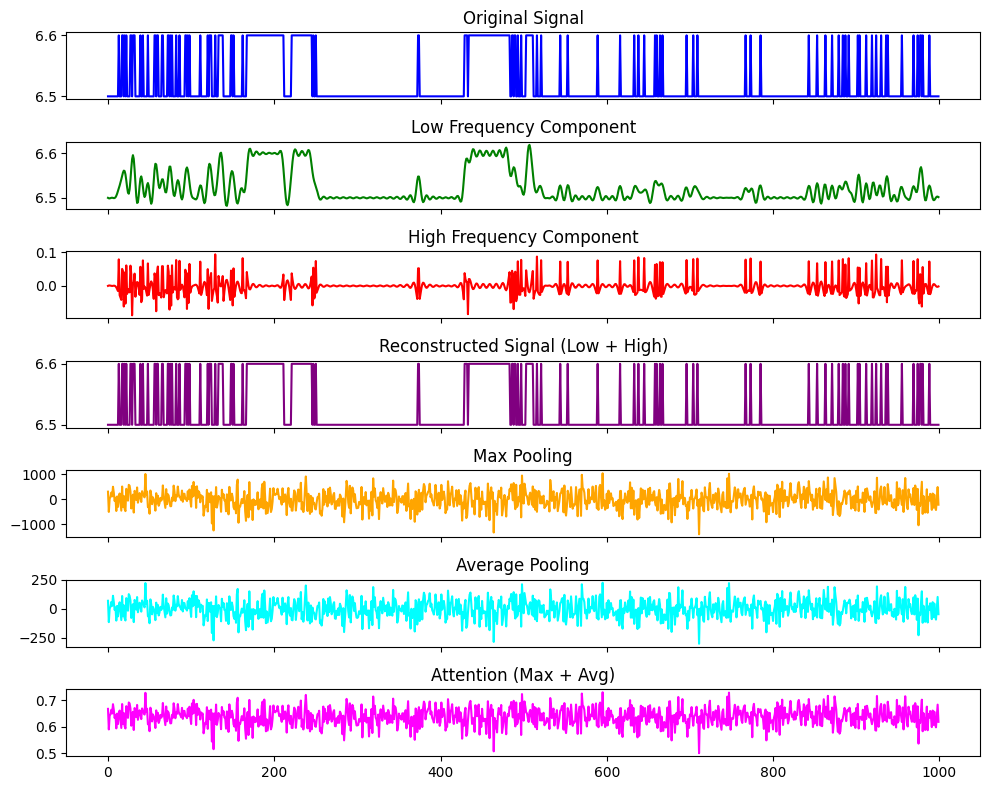

In [103]:
# Plot
fig, axes = plt.subplots(7, 1, figsize=(10, 8), sharex=True)

axes[0].plot(data[0, 0].numpy(), label='Original Signal', color='blue')
axes[0].set_title('Original Signal')

axes[1].plot(x_low[0, 0].numpy(), label='Low Frequency Component', color='green')
axes[1].set_title('Low Frequency Component')

axes[2].plot(x_high[0, 0].numpy(), label='High Frequency Component', color='red')
axes[2].set_title('High Frequency Component')

axes[3].plot(x_low[0, 0].numpy() + x_high[0, 0].numpy(),
             label='Reconstructed Signal', color='purple')
axes[3].set_title('Reconstructed Signal (Low + High)')

axes[4].plot(data_mp[0, 0].detach().numpy(), label='Max Pooling', color='orange')
axes[4].set_title('Max Pooling')

axes[5].plot(data_ap[0, 0].detach().numpy(), label='Average Pooling', color='cyan')
axes[5].set_title('Average Pooling')

axes[6].plot(data_attention[0, 0].detach().numpy(), label='Attention (Max + Avg)', color='magenta')
axes[6].set_title('Attention (Max + Avg)')

plt.tight_layout()
plt.show()